# TSTpatching Notebook

 ### 1. Overview & Purpose
 
This notebook demonstrates a systematic approach to understanding and intervening in a Transformer-based time series classifier.
1. **Capture internal activations**.  Cache convolutional embeddings, self-attention outputs, and MLP activations for clean inputs.
2. **Perform targeted patches**. Replace activations from corrupted inputs with those from clean inputs at various granularities (entire heads, individual positions, or MLP layers).
3. **Quantify influence**. Measure how each patch affects the model’s class probabilities to locate the most critical components for correct predictions.
4. **Identify causal circuits**. Aggregate significant patches into a graph of input timesteps → attention heads to reveal pathways driving the model’s decisions.
5. **Visualize results**. Use heatmaps, saliency overlays, and network graphs to interpret and communicate findings.
 

### 2. Imports and Dependencies
- Common Python packages
- Utility / Helper functions for plotting and backend processing from utils.py file
- Aeon for TSC dataset loading
- TST architecture from TSTtrainer.py
- Widgets for interactive notebook

In [1]:
# autoreload for utils.py edits
%load_ext autoreload
%autoreload 2

import os
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))
os.chdir(project_root)

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# helper library
from Utilities.utils import (
    sweep_heads,
    sweep_layerwise_patch,
    sweep_mlp_layers,
    sweep_attention_head_positions,
    sweep_mlp_positions,
    plot_influence,
    plot_layerwise_influence,
    plot_mlp_influence,
    plot_head_position_patch_heatmap,
    plot_mlp_position_patch_heatmap,
    get_attention_saliency,
    plot_timeseries_with_attention_overlay,
    get_probs,
    find_critical_patches,
    build_causal_graph,
    plot_causal_graph,
    plot_structured_graph_with_heads,
    patch_multiple_attention_heads_positions,
    sweep_head_to_head_influence,
    sweep_head_to_output_deltas

)

from aeon.datasets import load_classification
from Utilities.TST_trainer import TimeSeriesTransformer

import ipywidgets as widgets
from ipywidgets import interact, IntSlider, FloatSlider

### 3. Dataset Preparation
Define the dataset we want to work on here, the preprocess it for model input.

Currently there are three options:
- JapaneseVowels (12 dimension, 9 classes)
- FaceDetection (144 dimensions, 2 classes) NOTE: *model has ~50% accuracy*
- Yoga (1 dimension, 2 classes)

In [2]:
DATASET_NAME = "JapaneseVowels"

In [3]:
X_train, y_train = load_classification(DATASET_NAME, split="train")
X_test, y_test = load_classification(DATASET_NAME, split="test")

# swap axes to (N, seq_len, 1) and convert to float32
def prep(X):
    X_np = X.astype(np.float32)
    return np.swapaxes(X_np, 1, 2)

X_test = torch.tensor(prep(X_test))
y_test = torch.tensor(y_test.astype(np.int64))

# print(f"X_test = {X_test.shape}, Y_test = {y_test.shape}")
print(f"Test set has {X_test.shape[0]} instances, each instance has {X_test.shape[1]} timesteps across {X_test.shape[2]} dimensions.")
print(f"For each instance in the test set there is a true label.")

Test set has 370 instances, each instance has 25 timesteps across 12 dimensions.
For each instance in the test set there is a true label.


### 4. Model Initialization
Set up the TST model and load the pretrained checkpoint.
- Use GPU if available, however evaluation completely feasible on a laptop.
- Model must be instantiated exactly as the pretrained one.

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# extract data dimensions
seq_len = X_test.shape[1]
input_dim = X_test.shape[2]
num_classes = y_test.max() + 1

# model parameters, do not change
model = TimeSeriesTransformer(
    input_dim=input_dim,
    num_classes=num_classes,
    seq_len=seq_len,
    d_model=128,
    n_head=8,
    num_encoder_layers=3,
    dim_feedforward=256,
    dropout=0.1
).to(device)

num_layers = len(model.transformer_encoder.layers)

# load pretrained model
MODEL_NAME = f"TST_models/TST_{DATASET_NAME.lower()}.pth"
model.load_state_dict(torch.load(MODEL_NAME, map_location=device, weights_only=True))

<All keys matched successfully>

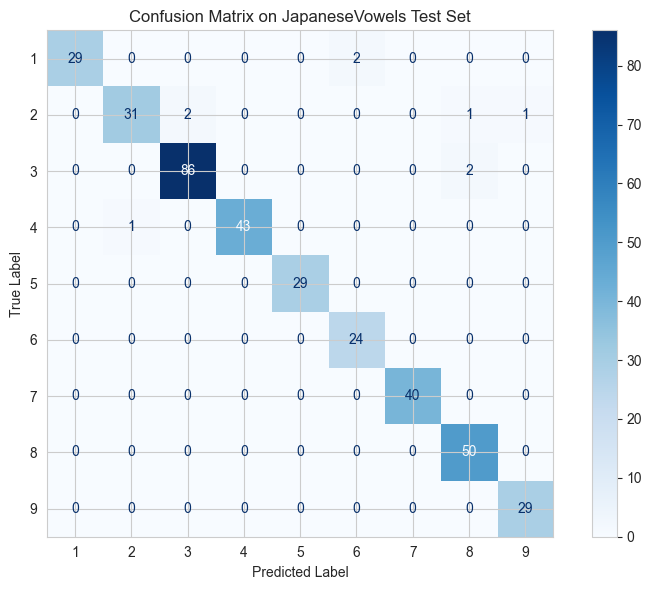

In [5]:
model.eval()

X_test_device = X_test.to(device)

with torch.no_grad():
    logits = model(X_test_device)
    predictions = torch.argmax(logits, dim=1).cpu().numpy()
    labels = y_test.cpu().numpy()

cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(1, 10))

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap="Blues", ax=ax, values_format="d")
plt.title(f"Confusion Matrix on {DATASET_NAME} Test Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


### 5. Identify Misclassified Examples
Scan trough the test set to find instances where the model predicts the wrong label.
- Sorted by confindence
- Reveal possible targets for patching

In [6]:
model.eval()
predictions = []
with torch.no_grad():
    for idx in range(len(X_test)):
        x = X_test[idx:idx+1].to(device)
        logits = model(x)
        probs  = torch.softmax(logits, dim=1)
        pred   = probs.argmax(dim=1).item()
        true   = y_test[idx].item()
        if pred:
            predictions.append({
                "idx": idx,
                "true_label": true,
                "pred_label": pred,
                "P_true": probs[0, true].item(),
                "P_pred": probs[0, pred].item()
            })

df = pd.DataFrame(predictions).sort_values(by="true_label", ascending=True)
df.reset_index(drop=True, inplace=True)
df

# SAVE TO EXCEL
# df.to_excel(f"TST_models/Model_Predictions/MODEL_predictions_{DATASET_NAME.lower()}.xlsx", index=False)



,idx,true_label,pred_label,P_true,P_pred
0,0,1,1,0.998692,0.998692
1,30,1,1,0.999819,0.999819
2,29,1,1,0.995696,0.995696
3,28,1,1,0.986441,0.986441
4,27,1,1,0.999683,0.999683
...,...,...,...,...,...
365,343,9,9,0.999846,0.999846
366,341,9,9,0.954030,0.954030
367,368,9,9,0.999839,0.999839
368,354,9,9,0.999651,0.999651


### 6. Selection of instances
1. Denoising: 
    - 1st: *Clean* instance (correct classification)
    - 2nd: *Corrupted* instance (misclassified)
2. Noising:
    - Vice-versa

In [ ]:
MODE = "denoise"

In [8]:
# CHOOSE 2 INSTANCES
idx_1 = 33 # CLEAN
idx_2 = 44 # CORRUPT

# move both instances to device and store ground truth
x1 = X_test[[idx_1]].to(device)
y1 = y_test[[idx_1]].item()

x2 = X_test[[idx_2]].to(device)
y2 = y_test[[idx_2]].item()

if MODE == "denoise":
    src, tgt       = x1,   x2
    src_label, tgt_label = y1,   y2
elif MODE == "noise":
    src, tgt       = x2, x1
    src_label, tgt_label = y2, y1
else:
    raise ValueError("MODE must be 'denoise' or 'noise'")

# verify model predictions
probs_x1 = torch.softmax(model(x1), dim=1)[0][y1].detach().cpu().numpy()
probs_x2 = torch.softmax(model(x2), dim=1)[0][y2].detach().cpu().numpy()
probs_x1_pct = probs_x1 * 100
probs_x2_pct = probs_x2 * 100

print(f"Instance {idx_1} ground truth label is {y1}, Instance {idx_2} ground truth label is {y2}.")
print(f"The model predicted {y1} for instance {idx_1} with {probs_x1_pct:.2f}% confidence. "
      f"For instance {idx_2} the confidence for label {y2} is {probs_x2_pct:.2f}%.")

Instance 33 ground truth label is 2, Instance 44 ground truth label is 2.
The model predicted 2 for instance 33 with 100.00% confidence. For instance 44 the confidence for label 2 is 10.72%.


### 7. Visualizing raw Time Series for the selected instances
First look at the structure of the sequences we are investigating

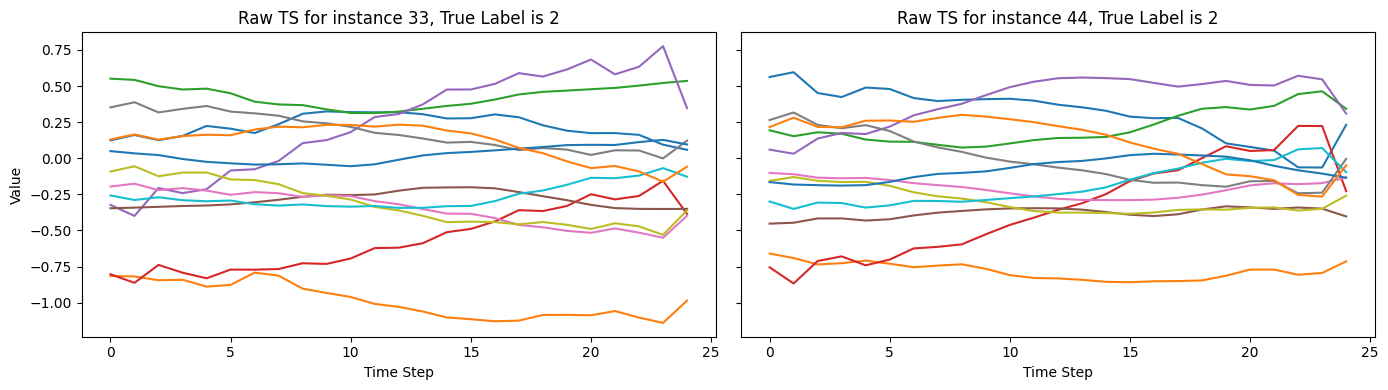

In [9]:
series_idx_1 = x1.cpu().numpy().squeeze()
series_idx_2 = x2.cpu().numpy().squeeze()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4), sharey=True)

axes[0].plot(x1.squeeze().cpu().numpy())
axes[0].set_title(f"Raw TS for instance {idx_1}, True Label is {y1}")
axes[0].set_xlabel("Time Step")
axes[0].set_ylabel("Value")

axes[1].plot(x2.squeeze().cpu().numpy())
axes[1].set_title(f"Raw TS for instance {idx_2}, True Label is {y2}")
axes[1].set_xlabel("Time Step")

plt.tight_layout()
plt.show()

## Patching Experiment: PATCHING EACH ATTENTION HEAD
- **get_probs** records the model's baseline prediction probabilities on the 2nd instance to provide a reference point.
- **sweep_heads** systematically patches each attention head (one at a time) from the first instance into the other while recording the resulting class probabilities.


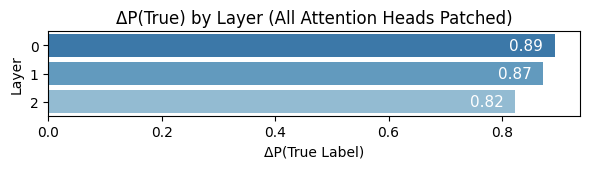

In [10]:
# Determine baseline
baseline = get_probs(model, tgt)

# Run patch sweep across layers (patch all heads at once per layer)
patched_probs_per_layer = sweep_layerwise_patch(model, src, tgt, num_classes)

# Plot ΔP per layer for the true label
plot_layerwise_influence(patched_probs_per_layer, baseline, tgt_label)


### Visualzing Influnece via Heatmap
**plot_influence** computes tbe change in proability  for true label and (ΔP) when each head is patched


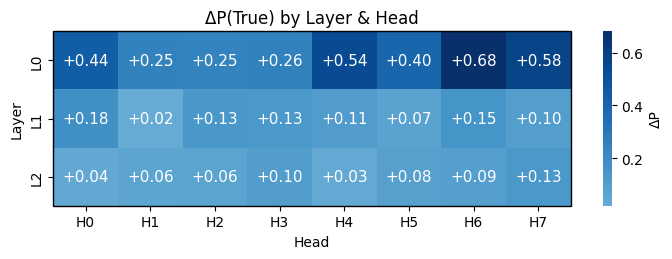

In [11]:
# PATCH EACH HEAD
patch_probs = sweep_heads(model, src, tgt, num_classes)
plot_influence(patch_probs, baseline, tgt_label)

X-axis: Attention heads.

Y-axis: Transformer layers.

Cell values: ΔP(true label).

**Interpretation**: Brighter colors indicate heads that, when patched, most improve the model's confidence in the true label

### Attention Overlay
Overlay the attention saliency scores onto the raw time series plots
- Choose a specific (*layer, head*) combination to inspect.

**get_attention_saliency** extracts per-timestep attention weights for each instance

**plot_timeseries_with_attention_overlay** displays the original time series with attention scores visualized as highlighted regions

In [12]:
@interact(
    layer_idx=IntSlider(min=0, max=num_layers-1, step=1, value=0),
    head_idx=IntSlider(min=0, max=7, step=1, value=0)
)
def plot_attention_overlay(layer_idx, head_idx):
    instances = [src, tgt]
    saliencies = [get_attention_saliency(model, inst, layer_idx, head_idx) for inst in instances]
    labels = ["Source", "Target"]

    plot_timeseries_with_attention_overlay(
        instances=[inst.squeeze(0) for inst in instances],
        saliencies=saliencies,
        labels=labels,
        title=f"Layer {layer_idx} Head {head_idx} Attention Overlay"
    )


interactive(children=(IntSlider(value=0, description='layer_idx', max=2), IntSlider(value=0, description='head…

The colored bands behind the time series indicate how much attention this head pays to each timestep.

Brighter mean higher attention.

Darker bands mean lower attention.

### Patching a specific head at each timestep

**sweep_attention_head_positions** patches the output of each individual head at every position (time step). It then records how patching at each position affects the model’s confidence in the true label.

**plot_head_position_patch_heatmap** shows how important each timestep is for the selected head

In [13]:
patch_probs_heads = sweep_attention_head_positions(model, src, tgt, num_layers, 8, seq_len, num_classes)

@interact(
    layer_idx=IntSlider(min=0, max=num_layers-1, step=1, value=0),
    head_idx=IntSlider(min=0, max=7, step=1, value=0)
)
def plot_patch_effect_heatmap(layer_idx, head_idx):
    plot_head_position_patch_heatmap(
        patch_probs=patch_probs_heads,
        baseline_probs=baseline,
        true_label=tgt_label,
        layer_idx=layer_idx,
        head_idx=head_idx,
        title=f"Head {head_idx} in Layer {layer_idx} - Patch Effect across Time Steps"
    )

interactive(children=(IntSlider(value=0, description='layer_idx', max=2), IntSlider(value=0, description='head…

X-axis: Time steps (positions).

Y-axis: Specific (layer, head) combination.

Colors: Change in model probability for the true label.

## Patching Experiment: PATCHING MLP LAYERS

**sweep_mlp_layers** patches the MLP output (after the second linear layer) of each transformer encoder layer individually

**plot_mlp_influence** visualizes the ΔP(true label) from patching each MLP layer

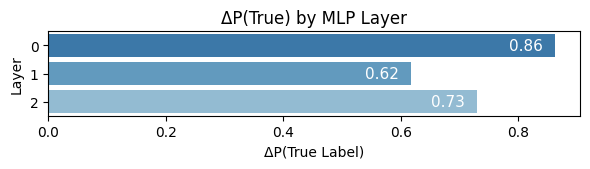

In [14]:
patch_probs_mlp = sweep_mlp_layers(model, src, tgt, num_classes=num_classes)
plot_mlp_influence(patch_probs_mlp, baseline, true_label=tgt_label)

X-axis: Transformer layers.

Y-axis: Change in model confidence for the true label.

**Interpretation**: Higher positive bars indicate layers whose MLP activations help recover the correct classification more.


### Patching MLP layer at a specific position
**sweep_mlp_positions** patches the MLP activation at each time step. Measure how patching each position’s MLP output affects the true label probability.

**plot_mlp_position_patch_heatmap** shows a heatmap of influence over layers and positions.

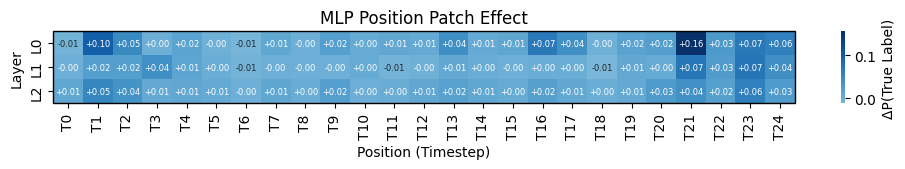

In [26]:
patch_probs_mlp_pos = sweep_mlp_positions(model, src, tgt, num_layers, seq_len, num_classes)
plot_mlp_position_patch_heatmap(
    patch_probs_mlp_pos, 
    baseline, 
    true_label=tgt_label,
    title="MLP Position Patch Effect"
)

X-axis: Time steps (positions).

Y-axis: Transformer layers.

Colors: Change in model probability for the true label.

## BUILDING CAUSAL GRAPHS

### Identify most critical inteventions and build a graph
- Select (layer, head, position) triples where patching yields a positive ΔP (above threshold).
- Create a directed graph where input timesteps point to important heads.
- Visualize the causal graph with nodes and weighted edges.

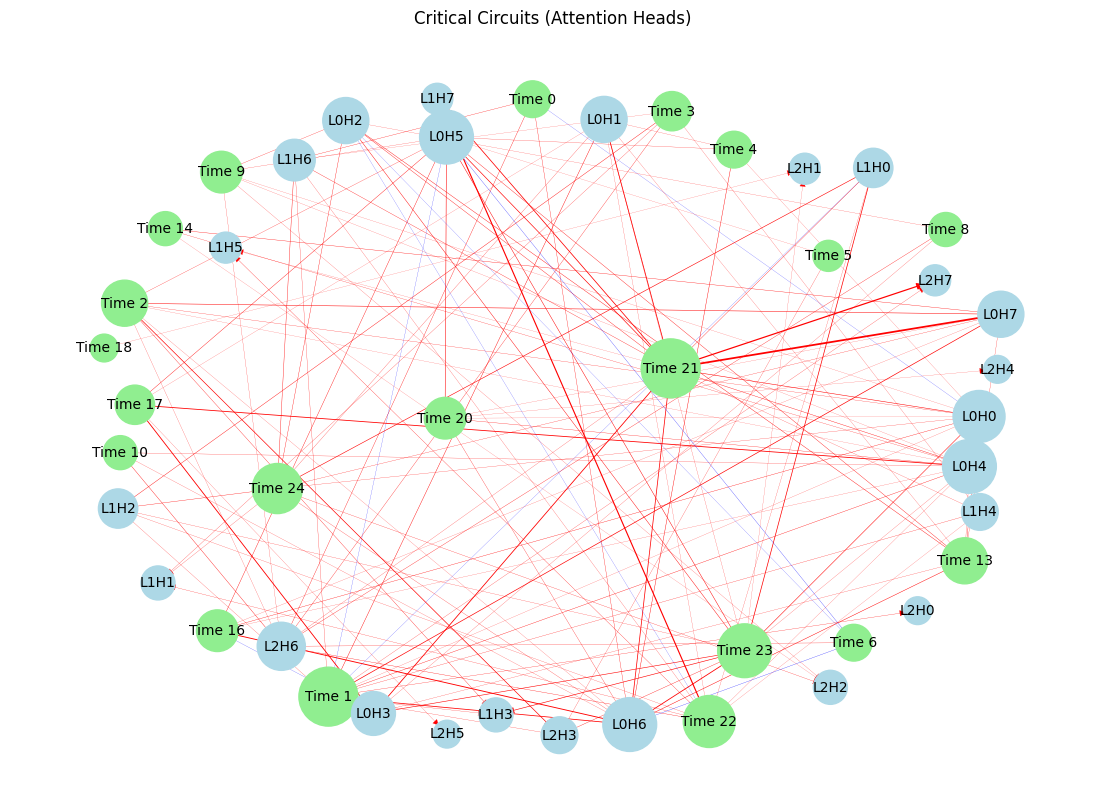

In [27]:
# define threshold
threshold = 0.01 # % of how much the probability must change

critical_patches = find_critical_patches(
    patch_probs_heads, 
    baseline,
    true_label=tgt_label,
    threshold=threshold
)

G = build_causal_graph(critical_patches)
plot_causal_graph(G, title="Critical Circuits (Attention Heads)")

**Input nodes**: Specific timesteps (e.g., "Time 12").

**Head nodes**: Attention heads (e.g., "L0H5").

Larger nodes imply more edges are connected to it.

Brighter edges imply magnitude of ΔP is larger after patching.

### Node Degrees and Edge Weights
**Node degrees**: How many edges connect to each node (importance as a hub).

**Edge weights**: How much each causal connection improves model performance.

Nodes and edges are ranked by influence

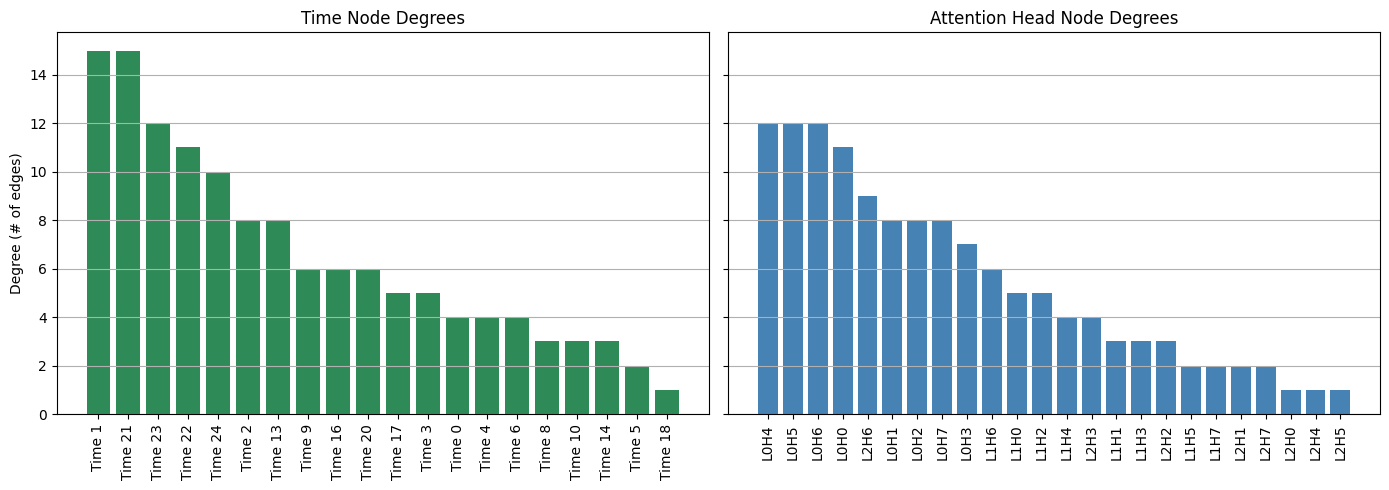

In [17]:
degrees = dict(G.degree())
sorted_degrees = sorted(degrees.items(), key=lambda x: x[1], reverse=True)
names = [x[0] for x in sorted_degrees]
values = [x[1] for x in sorted_degrees]

edges = list(G.edges(data=True))
sorted_edges = sorted(edges, key=lambda x: x[2]['weight'], reverse=True)
sources = [f"{u}->{v}" for u,v,d in sorted_edges]
weights = [d['weight'] for u,v,d in sorted_edges]

time_names = []
head_names = []
time_values = []
head_values = []

for name, val in zip(names, values):
    if name.startswith("Time"):
        time_names.append(name)
        time_values.append(val)
    elif name.startswith("L") and "H" in name:
        head_names.append(name)
        head_values.append(val)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)


axes[0].bar(time_names, time_values, color="seagreen")
axes[0].set_title("Time Node Degrees")
axes[0].set_ylabel("Degree (# of edges)")
axes[0].tick_params(axis='x', rotation=90)
axes[0].grid(axis='y')

axes[1].bar(head_names, head_values, color="steelblue")
axes[1].set_title("Attention Head Node Degrees")
axes[1].tick_params(axis='x', rotation=90)
axes[1].grid(axis='y')

plt.tight_layout()
plt.show()

## Interactive Experiment
Combining multiple critical patches affects model predictions.

1. Selects the top-k most influential edges.

2. Apply the clean activations to these multiple heads.

3. Report the change in confidence for the true label.

In [18]:
@interact(top_k=widgets.IntSlider(min=1, max=10, step=1, value=5))
def multi_patch_with_slider(top_k):
    critical_edges = sorted_edges[:top_k]
    logits_patched_multi = patch_multiple_attention_heads_positions(model, src, tgt, critical_edges)

    probs_multi = torch.softmax(logits_patched_multi, dim=1)[0].detach().cpu().numpy()
    delta_p_true_multi = probs_multi[tgt_label] - baseline[tgt_label]

    print(f"Top-k = {top_k}")
    print(f"ΔP(true) after multi-patching: {delta_p_true_multi:.4f}")
    print(f"Final P(true) after multi-patching: {probs_multi[tgt_label]:.4f}")

interactive(children=(IntSlider(value=5, description='top_k', max=10, min=1), Output()), _dom_classes=('widget…

In [19]:
influence_matrix = sweep_head_to_head_influence(model, src, tgt)
delta_p_matrix = sweep_head_to_output_deltas(model, src, tgt, tgt_label, num_classes)

In [20]:
def build_and_plot_graph(time_thresh=0.01,
                         head_thresh=0.15,
                         class_thresh=0.01):
    G = nx.DiGraph()

    # ---------- 1. Heads that pass the Head→Class test ----------
    selected_heads = {
        (l, h)
        for l in range(delta_p_matrix.shape[0])
        for h in range(delta_p_matrix.shape[1])
        if abs(delta_p_matrix[l, h]) > class_thresh          # keep only these
    }

    # ---------- 2. Class nodes ----------
    for c in range(num_classes):
        G.add_node(f"Class {c}")

    # ---------- 3. Head → Class edges (only selected heads) ----------
    for (l, h) in selected_heads:
        G.add_node(f"L{l}H{h}")
        G.add_edge(f"L{l}H{h}", f"Class {tgt_label}",
                   weight=float(delta_p_matrix[l, h]))

    # ---------- 4. Time → Head edges (only to selected heads) ----------
    for pos in range(patch_probs_heads.shape[2]):
        G.add_node(f"Time {pos}")
        for (l, h) in selected_heads:
            delta = patch_probs_heads[l, h, pos, tgt_label] - baseline[tgt_label]
            if abs(delta) > time_thresh:
                G.add_edge(f"Time {pos}", f"L{l}H{h}", weight=float(delta))

    # ---------- 5. Head → Head edges (optional: only among selected heads) ----------
    for (l1, h1) in selected_heads:
        for (l2, h2) in selected_heads:
            if l1 == l2:                # skip same-layer self-edges
                continue
            score = influence_matrix[l1, h1, l2, h2]
            if abs(score) > head_thresh:
                G.add_edge(f"L{l1}H{h1}", f"L{l2}H{h2}", weight=float(score))

    plot_structured_graph_with_heads(G)


In [21]:
interact(
    build_and_plot_graph,
    time_thresh=FloatSlider(value=0.01, min=0.0, max=0.5, step=0.005, description='Time→Head ΔP'),
    head_thresh=FloatSlider(value=0.15, min=0.0, max=0.5, step=0.01, description='Head→Head MSE'),
    class_thresh=FloatSlider(value=0.01, min=0.0, max=0.8, step=0.005, description='Head→Class ΔP')
)


interactive(children=(FloatSlider(value=0.01, description='Time→Head ΔP', max=0.5, step=0.005), FloatSlider(va…

<function __main__.build_and_plot_graph(time_thresh=0.01, head_thresh=0.15, class_thresh=0.01)>

In [22]:
def build_and_plot_topk(
    top_k:int,
    time_thresh:float = 0.0,
    head_thresh:float = 0.0,
    class_thresh:float = 0.0
):
    # first select the top_k critical_patches by |delta|
    top_raw = sorted(critical_patches, key=lambda x: abs(x[3]), reverse=True)[:top_k]

    # build the graph with *all* nodes but no edges yet
    G = nx.DiGraph()
    # add all Time nodes
    for pos in range(patch_probs_heads.shape[2]):
        G.add_node(f"Time {pos}")
    # add all Head nodes
    for l in range(patch_probs_heads.shape[0]):
        for h in range(patch_probs_heads.shape[1]):
            G.add_node(f"L{l}H{h}")
    # add all Class nodes
    for c in range(num_classes):
        G.add_node(f"Class {c}")

    # now add only those top_k edges Time→Head
    head_to_sum = {}
    head_set = set()
    for l, h, pos, delta in top_raw:
        if abs(delta) < time_thresh:
            continue
        source = f"Time {pos}"
        destination = f"L{l}H{h}"
        G.add_edge(source, destination, weight=delta)
        head_set.add((l,h))
        head_to_sum.setdefault((l,h), 0.0)
        head_to_sum[(l,h)] += delta
        print(f"{source} → {destination}, ΔP = {delta:.4f}")

    # you can filter by head_thresh here
    for l1 in range(influence_matrix.shape[0]):
        for h1 in range(influence_matrix.shape[1]):
            for l2 in range(influence_matrix.shape[2]):
                for h2 in range(influence_matrix.shape[3]):
                    if (l1,h1) not in head_set: 
                        continue
                    score = influence_matrix[l1, h1, l2, h2]
                    if abs(score) < head_thresh or l1==l2: 
                        continue
                    G.add_edge(f"L{l1}H{h1}", f"L{l2}H{h2}", weight=score)

    for (l,h), tot_delta in head_to_sum.items():
        if abs(tot_delta) < class_thresh:
            continue
        G.add_edge(f"L{l}H{h}", f"Class {tgt_label}", weight=tot_delta)
        
    plot_structured_graph_with_heads(G,
        title=f"Top {top_k} critical patches" )
    
# wire it up:
interact(
    build_and_plot_topk,
    top_k = IntSlider(min=1, max=len(critical_patches), step=1, value=5, description="Top-K"),
    time_thresh=FloatSlider(value=0.01, min=0.0, max=0.1, step=0.005, description='Time→Head ΔP'),
    head_thresh=FloatSlider(value=0.15, min=0.0, max=0.5, step=0.01, description='Head→Head MSE'),
    class_thresh=FloatSlider(value=0.01, min=0.0, max=0.5, step=0.005, description='Head→Class ΔP')
)


interactive(children=(IntSlider(value=5, description='Top-K', max=131, min=1), FloatSlider(value=0.01, descrip…

<function __main__.build_and_plot_topk(top_k: int, time_thresh: float = 0.0, head_thresh: float = 0.0, class_thresh: float = 0.0)>

# Scaling up! 


In [23]:
# where to dump everything
def make_results_root(base_dir, dataset_name, mode):
    """
    Construct a directory structure:
    base_dir / dataset_name / mode (noise or denoise)
    """
    root = os.path.join(base_dir, dataset_name, mode)
    os.makedirs(root, exist_ok=True)
    return root

In [ ]:

MODE = "noise"  # or "denoise"
OUT_ROOT = make_results_root("Results", DATASET_NAME, MODE)
MAX_PAIRS_PER_CLASS = 5

In [24]:
# --- Step 1: Build df of clean vs misclassified ---
records = []
model.eval()
with torch.no_grad():
    for idx in range(len(X_test)):
        x = X_test[idx:idx+1].to(device)
        logits = model(x)
        probs = torch.softmax(logits, dim=1)[0]
        pred, true = int(probs.argmax()), int(y_test[idx])
        records.append({
            "idx": idx,
            "true": true,
            "pred": pred,
            "P_true": float(probs[true]),
            "P_pred": float(probs[pred])
        })
df = pd.DataFrame(records)
df_clean = df[df.true == df.pred]
df_mis   = df[df.true != df.pred].sort_values("P_true")

# --- Step 2: Select class pairs ---
class_pairs = {}
for c in range(num_classes):
    mis_c = df_mis[df_mis.true == c].head(MAX_PAIRS_PER_CLASS)
    if mis_c.empty:
        continue
    clean_cands = df_clean[df_clean.true == c]
    if clean_cands.empty:
        continue
    clean_idx = int(clean_cands.iloc[0].idx)
    class_pairs[c] = [(clean_idx, int(r.idx)) for _, r in mis_c.iterrows()]

# --- Step 3: Accumulators ---
class_layer_deltas   = {c: [] for c in class_pairs}
class_head_deltas    = {c: [] for c in class_pairs}
class_headpos_deltas = {c: [] for c in class_pairs}

# --- Step 4: Run per-pair analysis ---
for c, pairs in class_pairs.items():
    for clean_idx, corrupt_idx in pairs:
        pair_dir = os.path.join(OUT_ROOT, f"class_{c}", f"pair_{clean_idx}_{corrupt_idx}")
        os.makedirs(pair_dir, exist_ok=True)

        x1 = X_test[[clean_idx]].to(device)
        x2 = X_test[[corrupt_idx]].to(device)
        y2 = int(y_test[corrupt_idx])

        baseline = get_probs(model, x2)

        pl = sweep_layerwise_patch(model, x1, x2, num_classes)
        plot_layerwise_influence(pl, baseline, y2)
        plt.savefig(os.path.join(pair_dir, "patch_all_heads_per_layer.png"))
        plt.close()
        class_layer_deltas[c].append(pl[:, c] - baseline[c])

        ph = sweep_heads(model, x1, x2, num_classes)
        plot_influence(ph, baseline, y2)
        plt.savefig(os.path.join(pair_dir, "patch_each_head_heatmap.png"))
        plt.close()
        class_head_deltas[c].append(ph[:, :, c] - baseline[c])

        sal1 = get_attention_saliency(model, x1.squeeze(0), 0, 0)
        sal2 = get_attention_saliency(model, x2.squeeze(0), 0, 0)
        plot_timeseries_with_attention_overlay([x1.squeeze(0), x2.squeeze(0)], [sal1, sal2], ["clean", "corrupt"], title="Overlay L0H0")
        plt.savefig(os.path.join(pair_dir, "attention_overlay_L0H0.png"))
        plt.close()

        p_hp = sweep_attention_head_positions(model, x1, x2, num_layers, 8, seq_len, num_classes)
        for l in range(num_layers):
            for h in range(8):
                plot_head_position_patch_heatmap(p_hp, baseline, y2, layer_idx=l, head_idx=h, title=f"L{l}H{h}")
                plt.savefig(os.path.join(pair_dir, f"patch_pos_L{l}H{h}.png"))
                plt.close()
        class_headpos_deltas[c].append(p_hp[..., c] - baseline[c])

        pm = sweep_mlp_layers(model, x1, x2, num_classes)
        plot_mlp_influence(pm, baseline, y2)
        plt.savefig(os.path.join(pair_dir, "patch_mlp_layers.png"))
        plt.close()

        pm_pos = sweep_mlp_positions(model, x1, x2, num_layers, seq_len, num_classes)
        plot_mlp_position_patch_heatmap(pm_pos, baseline, y2)
        plt.savefig(os.path.join(pair_dir, "patch_mlp_positions.png"))
        plt.close()

        crit = find_critical_patches(p_hp, baseline, y2, threshold=0.01)
        G = build_causal_graph(crit)
        plot_causal_graph(G)
        plt.savefig(os.path.join(pair_dir, "causal_graph.png"))
        plt.close()

        top5 = sorted(crit, key=lambda x: abs(x[3]), reverse=True)[:5]
        edges = [(f"Time {pos}", f"L{layer}H{head}", {"weight": delta}) for layer, head, pos, delta in top5]
        logits_top5 = patch_multiple_attention_heads_positions(model, x1, x2, edges)
        probs_top5 = torch.softmax(logits_top5, dim=1)[0].detach().cpu().numpy()
        delta_top5 = probs_top5[y2] - baseline[y2]

        inf_h2h = sweep_head_to_head_influence(model, x1, x2)
        d_p     = sweep_head_to_output_deltas(model, x1, x2, y2, num_classes)

        np.savez(os.path.join(pair_dir, "raw_results.npz"),
            baseline=baseline,
            layer_patch=pl,
            head_patch=ph,
            head_pos_patch=p_hp,
            mlp_patch=pm,
            mlp_pos_patch=pm_pos,
            inf_h2h=inf_h2h,
            delta_h2c=d_p
        )

        pd.DataFrame([{
            "clean_idx": clean_idx,
            "corrupt_idx": corrupt_idx,
            "true_label": y2,
            "baseline_P": float(baseline[y2]),
            "P_after_multi5": float(probs_top5[y2]),
            "delta_multi5": float(delta_top5)
        }]).to_csv(os.path.join(pair_dir, "summary.csv"), index=False)

# --- Step 5: Aggregate per class ---
for c in class_pairs:
    class_dir = os.path.join(OUT_ROOT, f"class_{c}")
    os.makedirs(class_dir, exist_ok=True)

    avg_layer = np.mean(np.stack(class_layer_deltas[c]), axis=0)
    avg_head = np.mean(np.stack(class_head_deltas[c]), axis=0)
    avg_headpos = np.mean(np.stack(class_headpos_deltas[c]), axis=0)

    np.savez(os.path.join(class_dir, "aggregated_deltas.npz"),
        avg_layer=avg_layer,
        avg_head=avg_head,
        avg_headpos=avg_headpos
    )

    plt.figure(figsize=(6,4))
    plt.bar(range(num_layers), avg_layer, color=plt.cm.Blues(0.6))
    plt.xlabel("Layer")
    plt.ylabel("Avg ΔP")
    plt.title(f"Class {c} — Avg ΔP per Layer")
    plt.tight_layout()
    plt.savefig(os.path.join(class_dir, "class_avg_layer.png"))
    plt.close()

    plt.figure(figsize=(8,6))
    plt.imshow(avg_head, aspect='auto', cmap="Blues",
               vmin=avg_head.min(), vmax=avg_head.max())
    plt.colorbar(label="Avg ΔP")
    plt.xlabel("Head")
    plt.ylabel("Layer")
    plt.title(f"Class {c} — Avg ΔP per Head")
    plt.tight_layout()
    plt.savefig(os.path.join(class_dir, "class_avg_head_heatmap.png"))
    plt.close()

    L, H, P = avg_headpos.shape
    arr = avg_headpos.reshape(L*H, P)
    ylabels = [f"L{i}H{j}" for i in range(L) for j in range(H)]

    plt.figure(figsize=(12, L*H*0.3))
    sns.heatmap(arr, cmap="Blues", center=0,
                xticklabels=max(P//20, 1), yticklabels=ylabels,
                cbar_kws={'label':'Avg ΔP'})
    plt.xlabel("Time Step")
    plt.ylabel("Layer×Head")
    plt.title(f"Class {c} — Avg ΔP Head×Position")
    plt.tight_layout()
    plt.savefig(os.path.join(class_dir, "class_avg_headpos_heatmap.png"))
    plt.close()

print("Done!")